# Forecasting and Modeling Crypto Prices
To start off we need to import all of the libraries that we will be using for this notebook and since we will be modeling the data two different ways we will import Prophet and also pycaret.

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
from fbprophet import Prophet
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8.27)})

The next thing that needs to be done is loading in the data that we previously pulled, and then just checking to make sure everything is looking right.

In [43]:
df=pd.read_csv(r'C:\Users\riellygriff21\Projects\crypto_prices.csv')
df['ds']=pd.to_datetime(df['ds'])
df.tail()

,ds,y
710,2021-05-19 13:00:00,39342.93
711,2021-05-19 14:00:00,38217.41
712,2021-05-19 15:00:00,38771.77
713,2021-05-19 16:00:00,39090.15
714,2021-05-19 17:00:00,39149.99


### Prophet Model
Prophet is great to use because it can give you fairly accurate predictions for time series with littling to no tuning needed.  This makes for a very smooth and simple process when working with time series.

For this model we will first split our data into a training and testing group with the test group just consisting of the last three days of the data that we pulled.

In [44]:
train=df.iloc[:-72,:]
test=df.iloc[-72:,:]

What we can do now is simply train our model on the training data set and then use the test data set to get a prediction for the future that we can evaluate the accuracy of. We can see the first couple of predictions that is gives us below.

In [45]:
model=Prophet()
model.fit(train)
preds=model.predict(test)
preds[['ds','yhat']].head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat
0,2021-05-16 18:00:00,47252.915212
1,2021-05-16 19:00:00,47314.334698
2,2021-05-16 20:00:00,47328.361596
3,2021-05-16 21:00:00,47301.347820
4,2021-05-16 22:00:00,47267.377384


To get a better idea of how the next 72 hours will look after the training data we can plot the training data with our new predictions. Prophet will even give us an upper and lower confidence interval for the predictions that it makes, this is the blue area around the line.

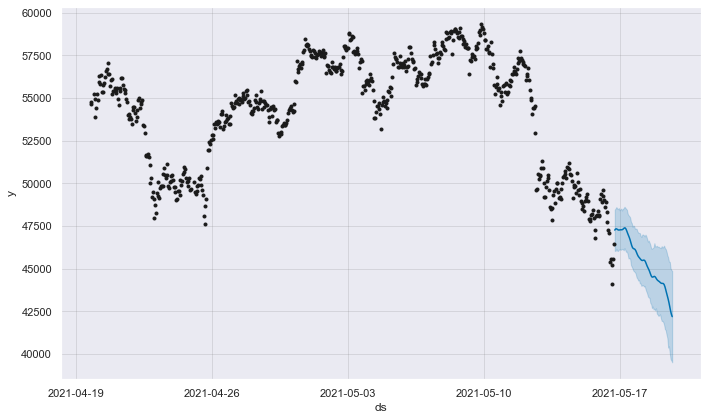

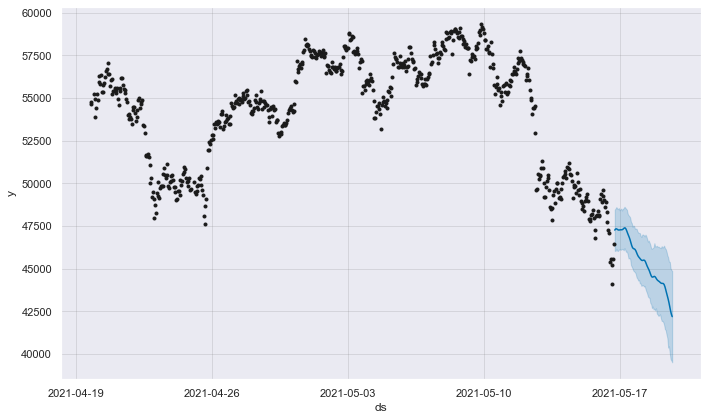

In [46]:
model.plot(preds)

In order to see how accurate our model really is we can plot the predicted values for all of the times over the actual values and see how closely they line up. We should really keep an eye on the last 72 hours since it was not included in the training data set.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


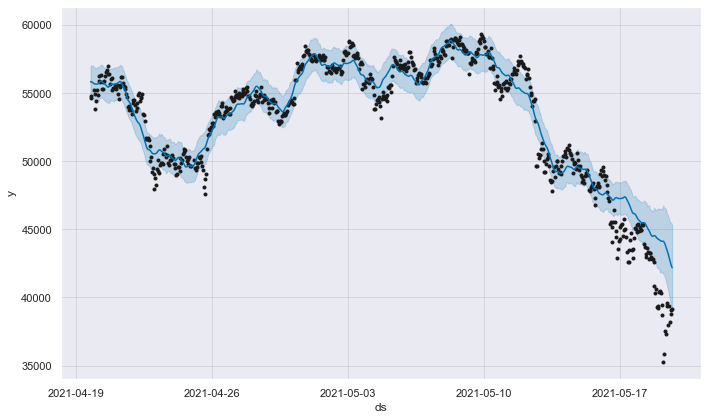

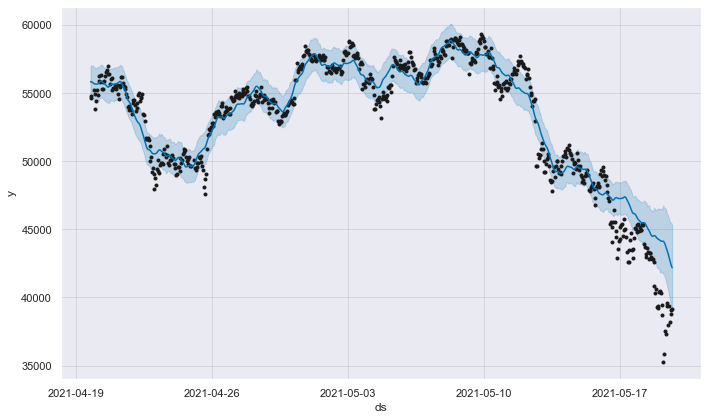

In [52]:
all_pred=model.predict(df)
model_full=Prophet()
model_full.fit(df)
model_full.plot(all_pred)

We can see that although it is not exactly accurate we can get a pretty good rough estimate of what the prices will be like in the 72 hours following the data that we trained on.

To get a number for how accurate the predictions are we can use the mean absolute error to see how far each prediction is from the actual price over the 30 days and this can be seen below.

In [54]:
mean_absolute_error(df['y'],all_pred['yhat'])

943.7966084209746

### Pycaret Models
Pycaret uses a variety of machine learning models and pretty much ranks them in order based on their accuracy with predictions.

Since pycaret can't do much with just a date stamp we are going to have to alter the data a little bit so that it can be understood.  We are just making a colounm for each part of the date. (year, month, day, time) Then we can put it in a new data frame that has the coloumns that we can use. We will also still be splitting this data into a training and testing data set the same way that we did with the previous model.

In [31]:
df['year']=[i.year for i in df['ds']]
df['month']=[i.month for i in df['ds']]
df['day']=[i.day for i in df['ds']]
df['time']=[i.hour for i in df['ds']]
df['series'] =np.arange(1,len(df)+1)
df=df[['series','year','month','day','time','y']]
df.head()
train=df.iloc[:-72,:]
test=df.iloc[-72:,:]

Now that all of our data is nice and ready we can setup our pycaret regression modeling. The main parts here are choosing the target which is 'y' or the price of the crypto, and specifying which variables are categorical and which are numerical.  It will automatically infere which is which but since it didn't get some right I had to put it in manually.

Once we have it all setup we can compare all of the models to see which ones preform best. In the case I am using the mean absolute error as the main comparison since that is what we used with Prophet.  We will then take the top three of those models to compare.

In [38]:
s=setup(data=train,test_data=test,target='y',fold_strategy='timeseries',fold=3,
        numeric_features=['series','year','time'],categorical_features=['month','day'])

best=compare_models(n_select=3,sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,3191.6997,20094899.8669,3831.1287,-1.6255,0.0000,0.0615,0.0533
gbr,Gradient Boosting Regressor,3324.7627,22326204.2572,3943.3364,-1.6927,0.0000,0.0642,0.0433
lightgbm,Light Gradient Boosting Machine,3363.6865,21700135.4454,3996.4511,-1.8826,0.0000,0.0647,0.1900
dt,Decision Tree Regressor,3392.1611,22599065.5750,4004.4449,-1.8132,0.0000,0.0654,0.0133
rf,Random Forest Regressor,3428.0920,23340478.2200,4040.5875,-1.8340,0.0000,0.0661,0.3033
knn,K Neighbors Regressor,3532.5267,24693371.3333,4138.5195,-1.9572,0.0000,0.0681,0.0567
et,Extra Trees Regressor,4128.8550,27691268.1950,4675.1531,-4.1425,0.0000,0.0783,0.3000
llar,Lasso Least Angle Regression,4920.6605,40225154.8582,5547.4894,-9.7909,0.0000,0.0918,0.0167
huber,Huber Regressor,5073.2137,42278337.1924,5751.8027,-8.9387,0.0000,0.0954,0.0367
ridge,Ridge Regression,5204.3265,44363468.0000,5869.6363,-9.3802,0.0000,0.0978,0.0133


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 2
INFO:logs:[AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=5848), GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5848, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
            

With the top three models selected we are going to get the predictions for each and plot it over the actual data so that we can get a visualization of the accuracy of each of the top three models.

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=5848), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


<AxesSubplot:xlabel='series', ylabel='Label'>

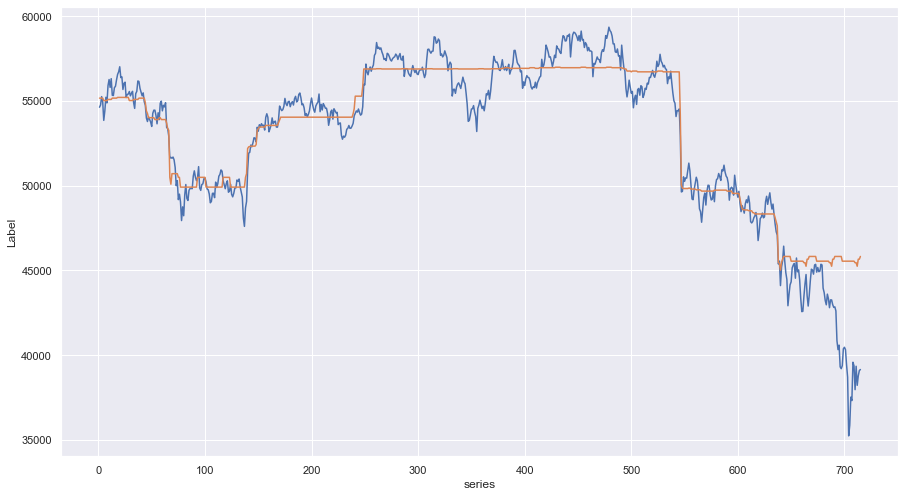

In [39]:
predictions=predict_model(best[0],data=df)
sns.lineplot(x=predictions['series'],y=predictions['y'])
sns.lineplot(x=predictions['series'],y=predictions['Label'])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=5848, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


<AxesSubplot:xlabel='series', ylabel='Label'>

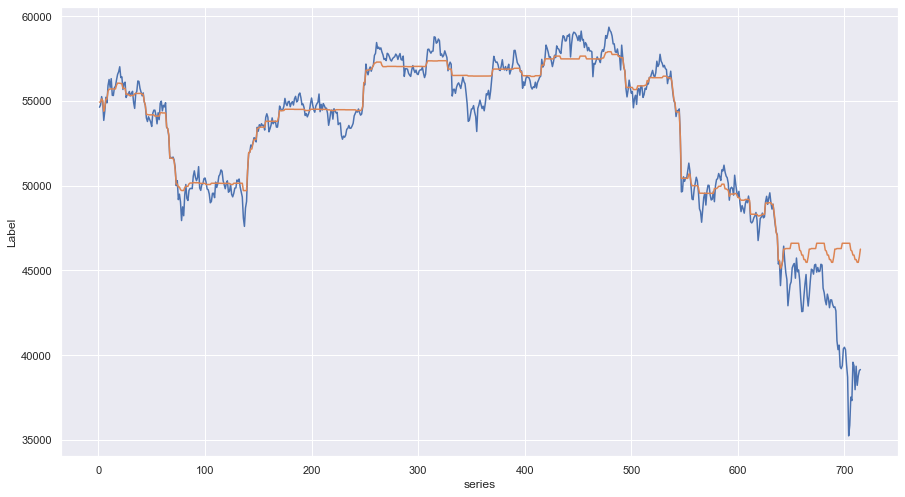

In [40]:
predictions=predict_model(best[1],data=df)
sns.lineplot(x=predictions['series'],y=predictions['y'])
sns.lineplot(x=predictions['series'],y=predictions['Label'])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=5848, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


<AxesSubplot:xlabel='series', ylabel='Label'>

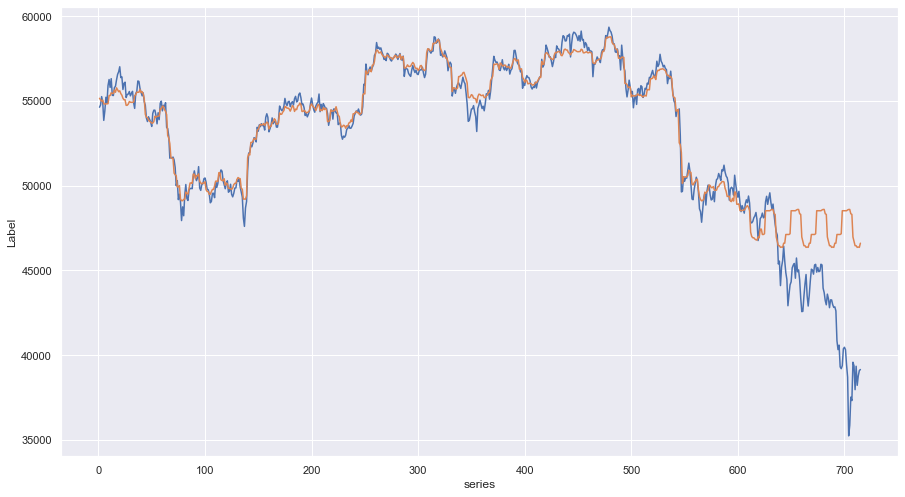

In [41]:
predictions=predict_model(best[2],data=df)
sns.lineplot(x=predictions['series'],y=predictions['y'])
sns.lineplot(x=predictions['series'],y=predictions['Label'])

## Conclusion
We can see from the above graphs that the machine learning models from pycaret do not do so well in predicting the test data even if some do really well on the training. We can also compare the mean absolute error for these ML models with that of the Prophet model and see that Prophet is more than 3x less than the others.  Moving forward I would just use the Prophet model trained on all of the data for future predictions since it has been shown to be the most accurate for now.